# Import

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import shutil

# Data load

In [2]:
#----------------------------------------------------------** Load the data: the cats vs dogs dataset
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
# !unzip -q kagglecatsanddogs_5340.zip -y
# !ls

# 손상된 이미지 걸러내기

In [42]:
#----------------------------------------------------------** Filter out corrupted images (손상된 이미지 전처리)
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        #print(fname)
        fpath = os.path.join(folder_path,fname)
        if str(".ipython_checkpoints") == fname:
            shutil.rmtree(fpath)
        else:
            #print(fpath) #제거되는 파일 확인
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
                #헤더에 jfif가 없으면 손상된 파일이므로 이미지를 구분하기 전에 전처리 한다.
                #오픈이 되는것을 봐선 손상된것인지 아닌지 이미지로 확인하긴 어려우나 해드에 jfif가 없으면 삭제힌다.
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped +=1
                #Delete corrupted image
                os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 999 images


# 데이터 셋 생성

In [5]:
#----------------------------------------------------------** 데이터 셋 생성
image_size = (180,180)
batch_size = 32 #tensorshape(32,180,180,3)

# train_ds = tf.keras.preprocessing.image_dataset_from_directory("PetImages",
#                                                                validation_split=0.2,
#                                                                subset="training",
#                                                                seed=1337,
#                                                                image_size=image_size,
#                                                                batch_size=batch_size,
#                                                                )
# val_ds = tf.keras.preprocessing.image_dataset_from_directory("PetImages",
#                                                              validation_split=0.2,
#                                                              subset="validation",
#                                                              seed=1337,
#                                                              image_size=image_size,
#                                                              batch_size=batch_size,
#                                                              )

# 이미지 확인

2022-11-16 13:17:15.959000: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


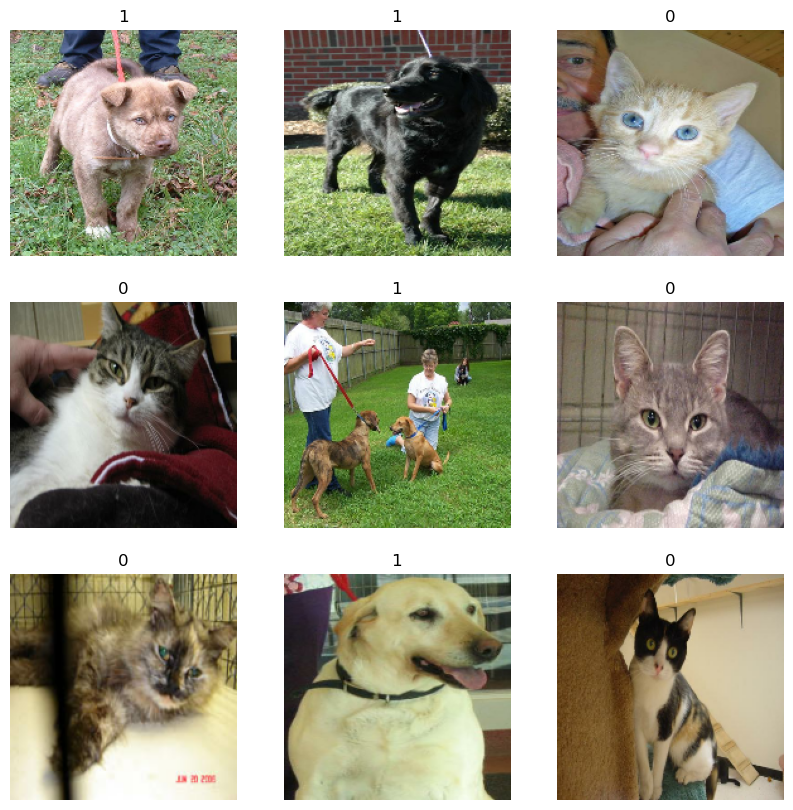

In [44]:
#----------------------------------------------------------** 이미지 확인

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1): #take를 사용하면 이터레이터가 적용되기때문에 계속 섞어가면서 데이터를 배치사이즈 만큼 뽑아온다. 원하는 갯수만큼 계속 추출가능하다.
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
        #plt.show() #파이참에서는 이것을 사용해야 출력된다.

# 데이터 증강
데이터 증강은 케라스에 레이터를 통과시켜 data_augmentation을 한다.

In [6]:
#----------------------------------------------------------** 이미지 데이터 증강
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Metal device set to: Apple M1 Pro


2022-11-16 14:03:36.475061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 14:03:36.475374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 증강된 이미지 확인

In [46]:
#----------------------------------------------------------** 증강된 이미지 확인
# plt.figure(figsize=(10,10))
# for images,_ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3,3,i+1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")
#         plt.show()
#

# 데이터 표준화
255로 나눠줘서 데이터를 작게 만들어야 한다. 큰값이 있으면 local minimum에 빠지기 쉬움으로 학습전에 데이터의 크기를 줄여야 한다.
train_ds에는 x에는 사진의 numpy값이 들어있고, y에는 라벨값이 들어 있다.
x에다가 데이터 증강하는 레이어를 적용한다. 트레이닝데이터에만 적용해야하기때문에 training을 True로 놓는다.

In [47]:
#----------------------------------------------------------**  데이터 표준화 standardization
#option 1
#inputs = keras.Input(shape=input_shape)
#x = data_augmentation(inputs)
#x = layers.Rescaling(1./255)(x)
#option 2
# augmented_train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True),y))

# 데이터 셋 생성
prefetch는 사용해도되고 안사용해도 된다.
cpu가 일하는것을 최적화하기위해 미리데이터를 불러와 메모리에 상주시킨다.

In [48]:
##----------------------------------------------------------** Configure the dataset for performance
train_ds=train_ds.prefetch(buffer_size=32)
val_ds=val_ds.prefetch(buffer_size=32)

# 모델생성
SeparableConv2D
입력 채널별로 따로따로 공간 방향의 합성곱 수행 후, 1*1 합성곱 (점별 합성곱)으로 출력 채널을 합치는 것.
이로 인해 공간 특성의 학습과 채널 방향 특성의 학습을 분리하는 효과를 얻을 수 있음.
모델 파라미터와 연산의 수를 크게 줄여주어 더 작고 빠른 모델을 제작할 수 있음.
여기서 1 * 1 합성곱이란,
1 * 1 크기의 Convolution Filter 사용한 Convolution Layer를 말하는데, Channel /  Spatial의 특성파악에 도움이 된다.
<img src="SeparableConv2D.png">

이렇게 1*1 합성곱을 쓰면 파라미터 수가 확연히 줄게 된다.
일반적으로 합성곱에서 channel을 크게 주면 파라미터 수가 급격히 증가하는데, 1*1 합성곱을 사용하면 효율적으로 모델을 구성할 수 있음. 즉, channel 수를 조절할 수 있음.
채널의 수가 줄면 파라미터가 줄어드는 것으로, 동시에 계산량이 같이 줄어듬.
이 특성들을 가지고 모델을 더 깊게 구성하면, 기존의 모델보다 더 많은 비선형성 활성화 함수를 사용할 수 있고, 더 구체적인 패턴을 파악해 성능 향상으로 이어짐.

In [3]:
(180,180)+(3,) #한개만 주게되면 concate가 안된다.

(180, 180, 3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

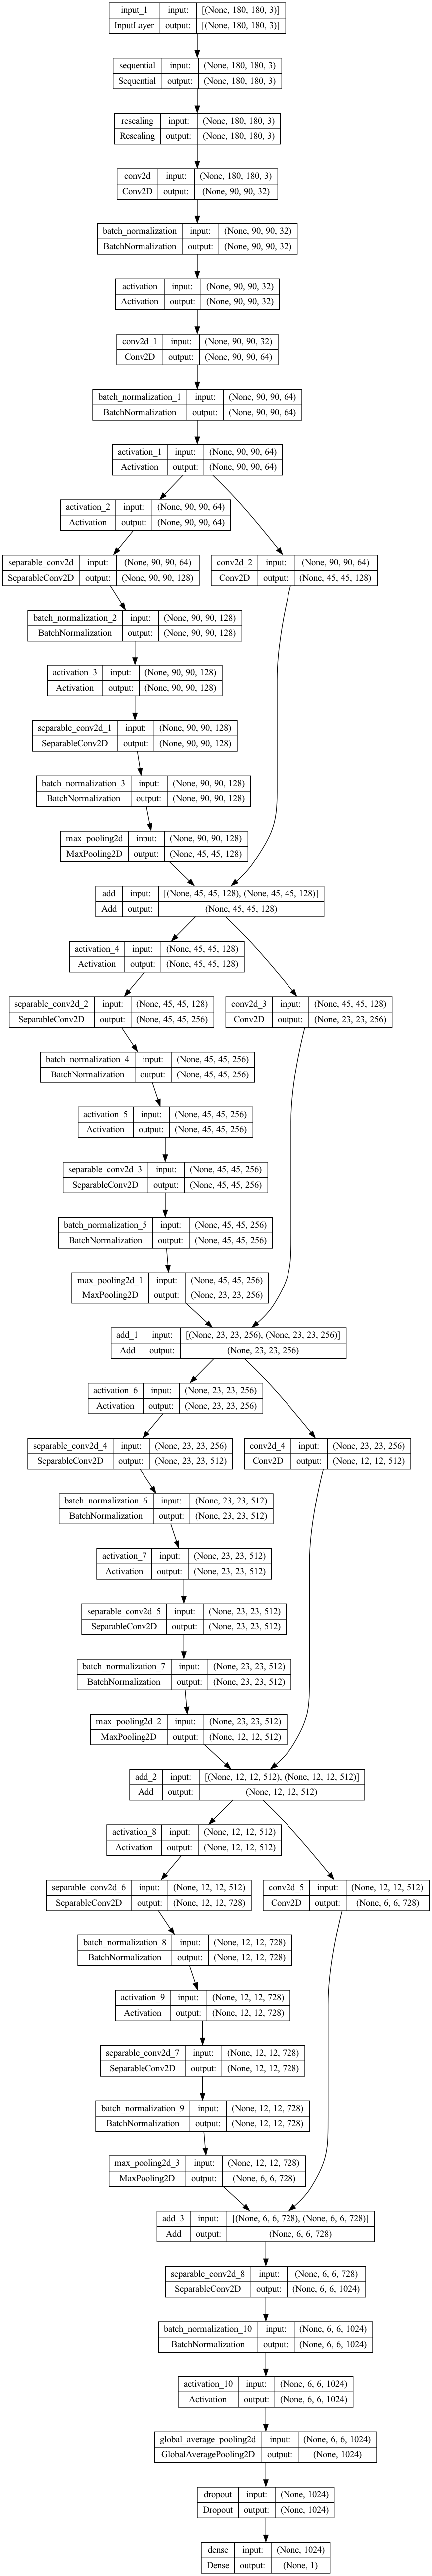

In [7]:
##----------------------------------------------------------** 모델구축
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0/255)(x) #모든데이터에 적용되어야 한다.
    x = layers.Conv2D(32,3,strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64,3,padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128,256,512,728]: #컨볼루전 레이어 4개를 입력시키고
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size,1,strides = 2, padding ="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x
    x = layers.SeparableConv2D(1024,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = 1

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size+(3,),num_classes=2)
#channel수를 넣어줘야 함으로 image_size에 (3,)을 더한다. (180,180,3)
model.summary()
keras.utils.plot_model(model, show_shapes=True)

# epochs = 50

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]

# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )
# model.fit(
#     train_ds,epochs=epochs,callbacks=callbacks,validation_data=val_ds
# )



# 추론
인터넷에서 사진을 하나 다운받아서 테스트를 해보자
<img src="cat.jpeg">

In [56]:
img = keras.preprocessing.image.load_img(
    "test_files/cat.jpeg",target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,0)

predictions = model.predict(img_array)
score = predictions[0]
print(
    "this image is %.2f percent cat and %.2f percent dog."
    %(100*(1-score),100*score)
)

1/1 [==============================] - 0s 17ms/step
this image is 89.29 percent cat and 10.71 percent dog.
